In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load audio file
audio_path = '/content/drive/My Drive/SonoSeq/Sample RP.m4a'
y, sr = librosa.load(audio_path)

<ipython-input-87-093e2cfe5c02>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


<ipython-input-88-b7034e34417f>:25: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(segment_y), ref=np.max)
<ipython-input-88-b7034e34417f>:94: RuntimeWarning: divide by zero encountered in log
  cepstrum = np.abs(np.fft.ifft(np.log(np.abs(np.fft.fft(frame)))**2))


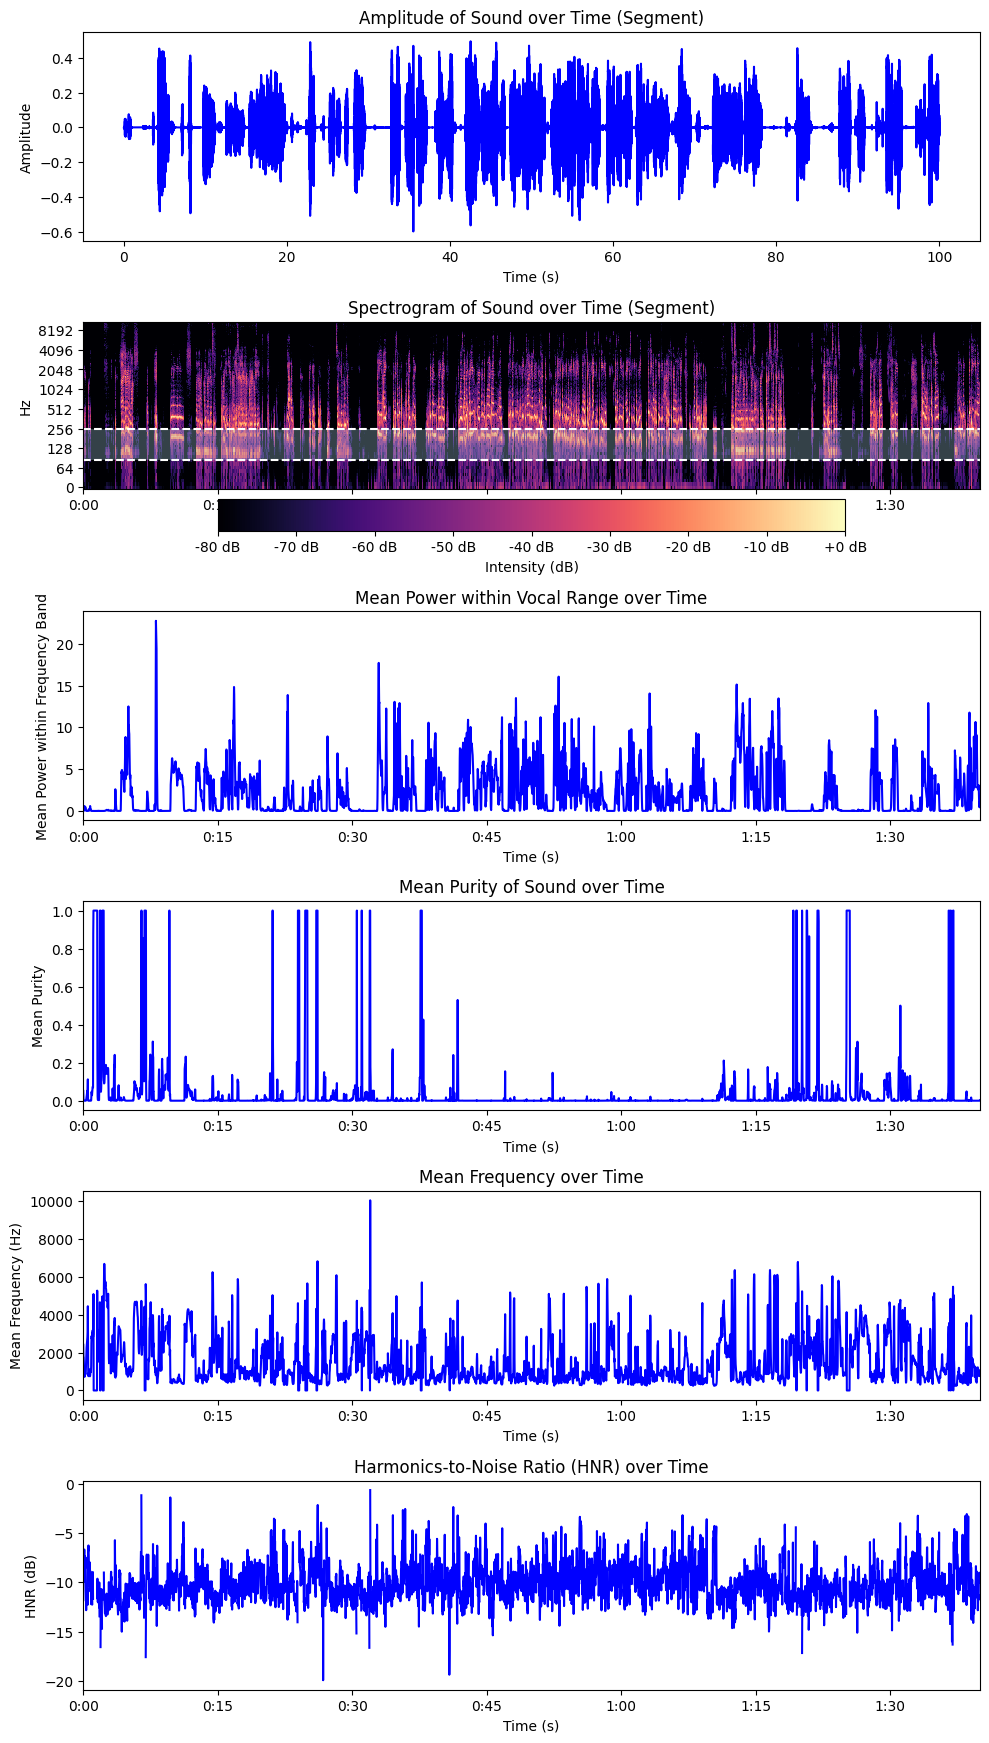

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Define the start and end times of the specific window
start_time = 0  # seconds
end_time = 100   # seconds

# Convert time to sample indices
start_sample = int(start_time * sr)
end_sample = int(end_time * sr)

# Extract the segment of the audio signal
segment_y = y[start_sample:end_sample]

# Plot the amplitude of sound over time for the segment (moved to the top)
plt.figure(figsize=(10, 20))  # Adjust the figure size if necessary
plt.subplot(7, 1, 1)  # Moved to the first subplot position
plt.plot(np.arange(len(segment_y)) / sr, segment_y, color='b')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude of Sound over Time (Segment)')

# Plot the spectrogram of the segment
D = librosa.amplitude_to_db(librosa.stft(segment_y), ref=np.max)
spec_ax = plt.subplot(7, 1, 2)  # Adjusted to the second subplot position
img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=spec_ax)
cbar = plt.colorbar(img, format='%+2.0f dB', orientation='horizontal', pad=0.05)
cbar.set_label('Intensity (dB)')
plt.title('Spectrogram of Sound over Time (Segment)')

# Draw horizontal dashed lines for vocal frequency range
min_freq = 85
max_freq = 255
plt.axhline(y=min_freq, color='white', linestyle='--', linewidth=1.5)
plt.axhline(y=max_freq, color='white', linestyle='--', linewidth=1.5)

# Highlight the range between min_freq and max_freq with a light blue rectangle
xmin, xmax = plt.xlim()
plt.axhspan(min_freq, max_freq, xmin=xmin, xmax=xmax, facecolor='lightblue', alpha=0.3)

# Compute the spectrogram for the segment within the time window
D_segment = np.abs(librosa.stft(segment_y))
times_segment = librosa.times_like(D_segment)
freqs_segment = librosa.fft_frequencies(sr=sr)

# Find the indices corresponding to the frequency band of interest
freq_indices = np.where((freqs_segment >= min_freq) & (freqs_segment <= max_freq))[0]

# Extract intensity values within the frequency band of interest and the time window
intensity_band_segment = np.mean(D_segment[freq_indices, :], axis=0)

# Plot intensity over time within the frequency band of interest and the time window
plt.subplot(7, 1, 3, sharex=spec_ax)  # Adjusted to the third subplot position
plt.plot(times_segment, intensity_band_segment, color='b')
plt.xlabel('Time (s)')
plt.ylabel('Mean Power within Frequency Band')
plt.title('Mean Power within Vocal Range over Time')

# Set a threshold for mean power
power_threshold = 0.5  # Adjust this threshold as needed

# Check if mean power exceeds the threshold
if np.mean(intensity_band_segment) > power_threshold:
    # Compute mean purity of sound over time
    mean_purity_segment = librosa.feature.spectral_flatness(y=segment_y)

    # Plot mean purity of sound over time
    plt.subplot(7, 1, 4, sharex=spec_ax)  # Adjusted to the fourth subplot position
    plt.plot(times_segment, mean_purity_segment[0], color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Mean Purity')
    plt.title('Mean Purity of Sound over Time')

# Compute mean frequency over time
mean_freq_segment = librosa.feature.spectral_centroid(y=segment_y, sr=sr)[0]

# Plot mean frequency over time
plt.subplot(7, 1, 5, sharex=spec_ax)  # Adjusted to the fifth subplot position
plt.plot(times_segment, mean_freq_segment, color='b')
plt.xlabel('Time (s)')
plt.ylabel('Mean Frequency (Hz)')
plt.title('Mean Frequency over Time')

# Define the window size and hop length for analysis (adjust as needed)
frame_length = 1024
hop_length = 512

# Compute the Harmonics-to-Noise Ratio (HNR) over time
hnr_values = []
for i in range(0, len(segment_y) - frame_length, hop_length):
    frame = segment_y[i:i + frame_length]
    # Compute the cepstrum
    cepstrum = np.abs(np.fft.ifft(np.log(np.abs(np.fft.fft(frame)))**2))
    # Compute the HNR as the ratio of the energy in the harmonics to the energy in the noise
    harmonics_energy = np.sum(cepstrum[1:10])  # Sum of the first 10 cepstral coefficients (excluding DC)
    noise_energy = np.sum(cepstrum[10:])  # Sum of the remaining cepstral coefficients
    hnr = harmonics_energy / noise_energy
    hnr_db = 10 * np.log10(hnr)  # Convert to dB
    hnr_values.append(hnr_db)

# Create a time array corresponding to the computed HNR values
time_values = np.arange(len(hnr_values)) * hop_length / sr

# Plot the Harmonics-to-Noise Ratio (HNR) over time
plt.subplot(7, 1, 6, sharex=spec_ax)  # Adjusted to the sixth subplot position
plt.plot(time_values, hnr_values, color='b')
plt.xlabel('Time (s)')
plt.ylabel('HNR (dB)')
plt.title('Harmonics-to-Noise Ratio (HNR) over Time')

plt.tight_layout()
plt.show()


In [ ]:
# Define the listener and caller arrays

listener_array = np.array([[13, 21],
                          [29, 31],
                          [73, 86],
                          [125, 149],
                          [154, 161],
                          [173, 176],
                          [182, 190],
                          [204, 206],
                          [213, 215],
                          [225, 241],
                          [251, 276],
                          [281, 286],
                          [292, 316], # steps done - 13
                          [386, 408],
                          [440, 458],
                          [537, 554],
                          [623, 645],
                          [705, 722],
                          [791, 811],
                          [859, 881],
                          [896, 911], # issue 1 done - 21
                          [1004, 1024],
                          [1110, 1126],
                          [1180, 1203],
                          [1275, 1307],
                          [1364, 1383],
                          [1432, 1462],
                          [1489, 1522],
                          [1571, 1598],
                          [1633, 1652],
                          [1678, 1728],
                          [1737, 1754], # issue 2 done - 32
                          [1765, 1777],
                          [1784, 1798],
                          [1806, 1829],
                          [1869, 1884],
                          [1926, 1953],
                          [1960, 1980],
                          [2030, 2055],
                          [2076, 2103],
                          [2171, 2188],
                          [2206, 2237],
                          [2250, 2308], # issue 3 done - 43
                          [2336, 2343],
                          [2353, 2365],
                          [2374, 2385]]) # post steps - 46

caller_array = np.array([[23, 27],
                        [33, 71],
                        [86, 123],
                        [151, 152],
                        [163, 171],
                        [176, 180],
                        [192, 202],
                        [208, 211],
                        [217, 223],
                        [243, 249],
                        [278, 279],
                        [288, 290],
                        [318, 384],
                        [410, 438],
                        [460, 535],
                        [556, 621],
                        [647, 703],
                        [724, 789],
                        [813, 857],
                        [883, 894],
                        [913, 1002],
                        [1026, 1108],
                        [1128, 1178],
                        [1205, 1273],
                        [1309, 1362],
                        [1385, 1430],
                        [1464, 1487],
                        [1524, 1569],
                        [1600, 1631],
                        [1654, 1676],
                        [1730, 1735],
                        [1756, 1763],
                        [1779, 1782],
                        [1800, 1804],
                        [1831, 1867],
                        [1886, 1924],
                        [1955, 1958],
                        [1982, 2028],
                        [2057, 2074],
                        [2105, 2169],
                        [2190, 2204],
                        [2239, 2248],
                        [2310, 2334],
                        [2345, 2351],
                        [2367, 2372],
                        [2387, 2394]])

In [ ]:
import numpy as np
import librosa

def calculate_mean_frequency_highest_intensity_vocal_range(start_time, end_time, y, sr):
    """
    Calculate the mean frequency of the highest intensity within the vocal range of a specified time range.

    Parameters:
    - start_time (float): Start time of the range in seconds.
    - end_time (float): End time of the range in seconds.
    - y (ndarray): Audio waveform.
    - sr (int): Sampling rate.

    Returns:
    - mean_frequency (float): Mean frequency of the highest intensity within the vocal range of the specified time range.
    """

    # Convert time to sample indices
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)

    # Extract the audio segment corresponding to the time range
    segment = y[start_sample:end_sample]

    # Compute the spectrogram of the audio segment
    D = np.abs(librosa.stft(segment))

    # Compute the frequencies corresponding to each time frame in the spectrogram
    freqs = librosa.fft_frequencies(sr=sr)

    # Define the vocal range (e.g., 85 Hz to 255 Hz)
    min_vocal_freq = 85
    max_vocal_freq = 255

    # Find the indices corresponding to the vocal range
    vocal_range_indices = np.where((freqs >= min_vocal_freq) & (freqs <= max_vocal_freq))[0]

    # Extract the spectrogram values within the vocal range
    vocal_range_spectrum = D[vocal_range_indices, :]

    # Find the frequency bin with the highest intensity for each time frame within the vocal range
    max_intensity_indices = np.argmax(vocal_range_spectrum, axis=0)

    # Extract the frequencies corresponding to the highest intensity bins within the vocal range
    frequencies_highest_intensity = freqs[vocal_range_indices][max_intensity_indices]

    # Compute the mean frequency of the highest intensity within the vocal range
    mean_frequency = np.mean(frequencies_highest_intensity)

    return mean_frequency

def calculate_average_power_vocal_range(start_time, end_time, y, sr):
    """
    Calculate the average power within the vocal range of a specified time range.

    Parameters:
    - start_time (float): Start time of the range in seconds.
    - end_time (float): End time of the range in seconds.
    - y (ndarray): Audio waveform.
    - sr (int): Sampling rate.

    Returns:
    - average_power (float): Average power within the vocal range of the specified time range.
    """

    # Convert time to sample indices
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)

    # Extract the audio segment corresponding to the time range
    segment = y[start_sample:end_sample]

    # Compute the spectrogram of the audio segment
    D = np.abs(librosa.stft(segment))

    # Compute the frequencies corresponding to each time frame in the spectrogram
    freqs = librosa.fft_frequencies(sr=sr)

    # Define the vocal range (e.g., 85 Hz to 255 Hz)
    min_vocal_freq = 85
    max_vocal_freq = 255

    # Find the indices corresponding to the vocal range
    vocal_range_indices = np.where((freqs >= min_vocal_freq) & (freqs <= max_vocal_freq))[0]

    # Extract the spectrogram values within the vocal range
    vocal_range_spectrum = D[vocal_range_indices, :]

    # Compute the average power within the vocal range
    average_power = np.mean(vocal_range_spectrum)

    return average_power

import librosa

def calculate_average_loudness_vocal_range(start_time, end_time, y, sr):
    """
    Calculate the average loudness (in decibels) within the vocal range of a specified time range.

    Parameters:
    - start_time (float): Start time of the range in seconds.
    - end_time (float): End time of the range in seconds.
    - y (ndarray): Audio waveform.
    - sr (int): Sampling rate.

    Returns:
    - average_loudness_db (float): Average loudness (in decibels) within the vocal range of the specified time range.
    """

    # Convert time to sample indices
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)

    # Extract the audio segment corresponding to the time range
    segment = y[start_sample:end_sample]

    # Compute the loudness (in decibels) of the audio segment
    loudness_db = librosa.amplitude_to_db(segment, ref=np.max)

    # Define the vocal range (e.g., 85 Hz to 255 Hz)
    min_vocal_freq = 85
    max_vocal_freq = 255

    # Compute the average loudness within the vocal range
    average_loudness_db = np.mean(loudness_db)

    return average_loudness_db

def calculate_total_pause_time(start_time, end_time, y, sr, threshold=-30):
    """
    Calculate the total time spent pausing (no voice) within a specified time range.

    Parameters:
    - start_time (float): Start time of the range in seconds.
    - end_time (float): End time of the range in seconds.
    - y (ndarray): Audio waveform.
    - sr (int): Sampling rate.
    - threshold (float): Threshold below which to consider the audio as pause (in decibels).

    Returns:
    - total_pause_time (float): Total time spent pausing (no voice) within the specified time range (in seconds).
    """

    # Convert time to sample indices
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)

    # Extract the audio segment corresponding to the time range
    segment = y[start_sample:end_sample]

    # Compute the loudness (in decibels) of the audio segment
    loudness_db = librosa.amplitude_to_db(segment, ref=np.max)

    # Count the number of frames below the threshold
    num_frames_below_threshold = np.sum(loudness_db < threshold)

    # Compute the duration of pauses (in seconds)
    frame_duration = 1 / sr  # Duration of each frame in seconds
    total_pause_time = num_frames_below_threshold * frame_duration

    return total_pause_time

def calculate_purity_of_sound(start_time, end_time, y, sr):
    """
    Calculate the purity of sound within the vocal range of a specified time range.

    Parameters:
    - start_time (float): Start time of the range in seconds.
    - end_time (float): End time of the range in seconds.
    - y (ndarray): Audio waveform.
    - sr (int): Sampling rate.

    Returns:
    - purity (float): Purity of sound within the vocal range of the specified time range.
    """

    # Convert time to sample indices
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)

    # Extract the audio segment corresponding to the time range
    segment = y[start_sample:end_sample]

    # Compute spectral flatness (purity of sound) for the audio segment
    spectral_flatness = librosa.feature.spectral_flatness(y=segment)

    # Compute the mean spectral flatness
    purity = np.mean(spectral_flatness)

    return purity



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Function to plot linear regression for given data and labels
def plot_linear_regression(x_values, y_values, x_label, y_label, title):
    # Create a DataFrame from the lists
    df = pd.DataFrame({x_label: x_values, y_label: y_values})

    # Add a constant term to the independent variable (x) for the regression model
    X = sm.add_constant(df[x_label])

    # Fit linear regression model
    model = sm.OLS(df[y_label], X).fit()

    # Plot linear regression
    plt.scatter(df[x_label], df[y_label], color='blue', label='Data Points')
    plt.plot(df[x_label], model.predict(X), color='blue', label='Best-fit line')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()

    # Add R-squared and p-value to the plot
    plt.text(0.1, 0.9, f'R-squared: {model.rsquared:.4f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.85, f'p-value: {model.pvalues[1]:.4f}', transform=plt.gca().transAxes)

# Function to plot subplots
def plot_subplots(listener_array, caller_array, start_interaction=None, end_interaction=None, figsize=(10, 8)):
    # Set figure size
    plt.figure(figsize=figsize)

    # Initialize lists to store x and y values
    x_values = []
    y_values = []

    # Loop over the elements of the arrays
    for i in range(len(listener_array)):
        if start_interaction is not None and end_interaction is not None:
            if i >= start_interaction and i <= end_interaction:
                pass
            else:
                continue

        # Calculate mean frequency for listener and caller arrays
        listener_mean_frequency = calculate_mean_frequency_highest_intensity_vocal_range(listener_array[i][0], listener_array[i][1], y, sr)
        caller_mean_frequency = calculate_mean_frequency_highest_intensity_vocal_range(caller_array[i][0], caller_array[i][1], y, sr)

        # Append values to lists
        x_values.append(listener_mean_frequency)
        y_values.append(caller_mean_frequency)

    plt.subplot(2, 2, 1)
    plot_linear_regression(x_values, y_values, 'Listener Frequency (Hz)', 'Caller Frequency (Hz)', 'Mean Frequencies Regression')

    # Initialize lists to store x and y values
    x_values = []
    y_values = []

    # Loop over the elements of the arrays
    for i in range(len(listener_array)):
        if start_interaction is not None and end_interaction is not None:
            if i >= start_interaction and i <= end_interaction:
                pass
            else:
                continue

        # Calculate purity of sound for listener and caller arrays
        listener_purity = calculate_purity_of_sound(listener_array[i][0], listener_array[i][1], y, sr)
        caller_purity = calculate_purity_of_sound(caller_array[i][0], caller_array[i][1], y, sr)

        # Append values to lists
        x_values.append(listener_purity)
        y_values.append(caller_purity)

    plt.subplot(2, 2, 2)
    plot_linear_regression(x_values, y_values, 'Listener Purity', 'Caller Purity', 'Purity of Sound Regression')

    # Initialize lists to store x and y values
    x_values = []
    y_values = []

    # Loop over the elements of the arrays
    for i in range(len(listener_array)):
        if start_interaction is not None and end_interaction is not None:
            if i >= start_interaction and i <= end_interaction:
                pass
            else:
                continue

        # Calculate average loudness for listener and caller arrays
        listener_average_loudness_db = calculate_average_loudness_vocal_range(listener_array[i][0], listener_array[i][1], y, sr)
        caller_average_loudness_db = calculate_average_loudness_vocal_range(caller_array[i][0], caller_array[i][1], y, sr)

        # Append values to lists
        x_values.append(listener_average_loudness_db)
        y_values.append(caller_average_loudness_db)

    plt.subplot(2, 2, 3)
    plot_linear_regression(x_values, y_values, 'Listener Average Loudness (dB)', 'Caller Loudness (dB)', 'Average Loudness Regression')

    # Initialize lists to store x and y values
    x_values = []
    y_values = []

    # Loop over the elements of the arrays
    for i in range(len(listener_array)):
        if start_interaction is not None and end_interaction is not None:
            if i >= start_interaction and i <= end_interaction:
                pass
            else:
                continue

        # Calculate total pause time for listener and caller arrays
        listener_total_pause_time = calculate_total_pause_time(listener_array[i][0], listener_array[i][1], y, sr, threshold = -60)
        caller_total_pause_time = calculate_total_pause_time(caller_array[i][0], caller_array[i][1], y, sr, threshold = -60)

        # Append values to lists
        x_values.append(listener_total_pause_time)
        y_values.append(caller_total_pause_time)

    plt.subplot(2, 2, 4)
    plot_linear_regression(x_values, y_values, 'Listener Total Pause Time (s)', 'Caller Total Pause Time (s)', 'Pause Time Regression')

    plt.tight_layout()
    plt.show()


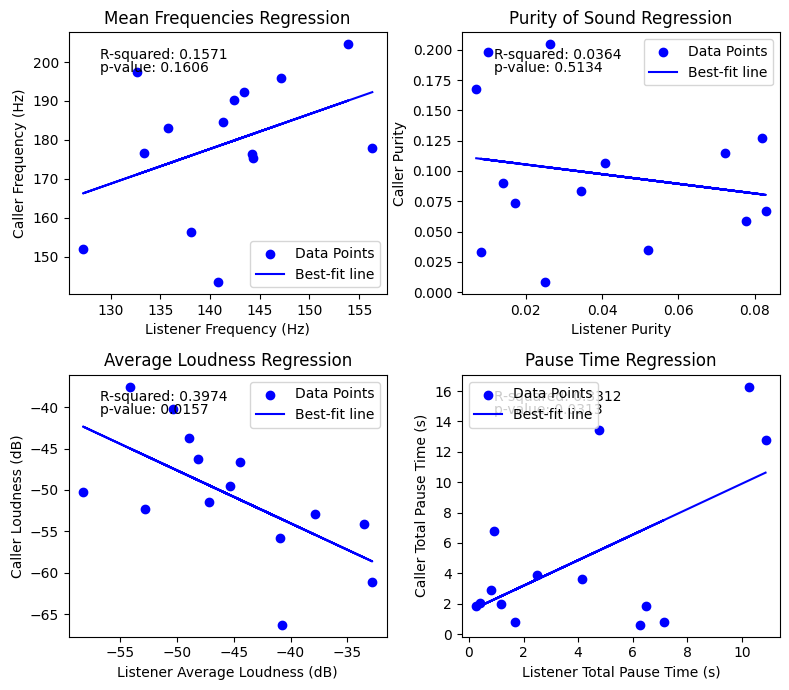

In [ ]:
# Call the function to plot subplots
plot_subplots(listener_array, caller_array, start_interaction=0, end_interaction=13, figsize=(8, 7)) # steps
#plot_subplots(listener_array, caller_array, start_interaction=14, end_interaction=21, figsize=(8, 7)) # issue 1
#plot_subplots(listener_array, caller_array, start_interaction=22, end_interaction=32, figsize=(8, 7)) # issue 2
#plot_subplots(listener_array, caller_array, start_interaction=32, end_interaction=43, figsize=(8, 7)) # issue 3
#plot_subplots(listener_array, caller_array, start_interaction=44, end_interaction=46, figsize=(8, 7)) # steps
##plot_subplots(listener_array, caller_array, start_interaction=0, end_interaction=46, figsize=(8, 7)) # steps

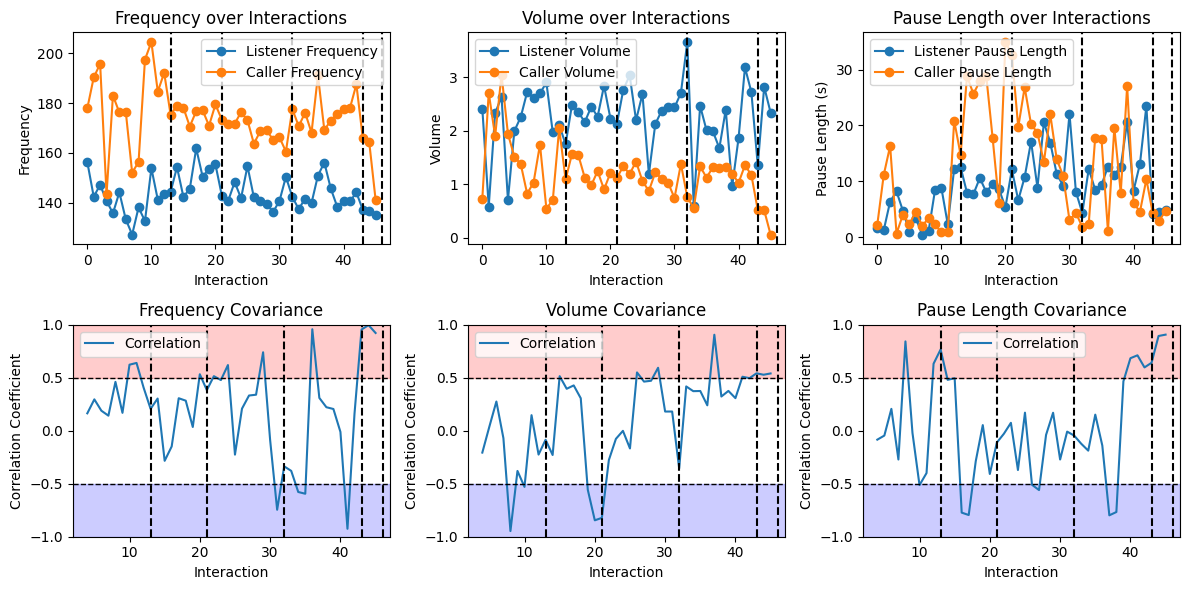

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to calculate the rolling correlation
def corr_roll(datax, datay, win):
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    return np.array(s2.rolling(win).corr(s1))

cov_window = 5

# Initialize lists to store frequency, volume, and pause length for each interaction
interaction_freq = []
interaction_volume = []
interaction_pause_length = []

# Loop over the elements of the arrays
for i in range(len(listener_array)):
    # Calculate frequency, volume, and pause length for listener and caller arrays
    listener_mean_frequency = calculate_mean_frequency_highest_intensity_vocal_range(listener_array[i][0], listener_array[i][1], y, sr)
    caller_mean_frequency = calculate_mean_frequency_highest_intensity_vocal_range(caller_array[i][0], caller_array[i][1], y, sr)
    listener_avg_power = calculate_average_power_vocal_range(listener_array[i][0], listener_array[i][1], y, sr)
    caller_avg_power = calculate_average_power_vocal_range(caller_array[i][0], caller_array[i][1], y, sr)
    listener_pause_time = calculate_total_pause_time(listener_array[i][0], listener_array[i][1], y, sr, threshold = -50)
    caller_pause_time = calculate_total_pause_time(caller_array[i][0], caller_array[i][1], y, sr, threshold = -50)

    # Append values to interaction lists
    interaction_freq.append((listener_mean_frequency, caller_mean_frequency))
    interaction_volume.append((listener_avg_power, caller_avg_power))
    interaction_pause_length.append((listener_pause_time, caller_pause_time))

# Plotting frequency, volume, and pause length over time
plt.figure(figsize=(12, 6))

# Subplot 1: Frequency over time
plt.subplot(2, 3, 1)
listener_freq_points = [freq[0] for freq in interaction_freq]
caller_freq_points = [freq[1] for freq in interaction_freq]
plt.plot(np.arange(len(interaction_freq)), listener_freq_points, 'o-', label='Listener Frequency')
plt.plot(np.arange(len(interaction_freq)), caller_freq_points, 'o-', label='Caller Frequency')
plt.xlabel('Interaction')
plt.ylabel('Frequency')
plt.title('Frequency over Interactions')
plt.legend()
plt.axvline(x=13, color='black', linestyle='--')
plt.axvline(x=21, color='black', linestyle='--')
plt.axvline(x=32, color='black', linestyle='--')
plt.axvline(x=43, color='black', linestyle='--')
plt.axvline(x=46, color='black', linestyle='--')

# Subplot 2: Volume over time
plt.subplot(2, 3, 2)
listener_vol_points = [vol[0] for vol in interaction_volume]
caller_vol_points = [vol[1] for vol in interaction_volume]
plt.plot(np.arange(len(interaction_volume)), listener_vol_points, 'o-', label='Listener Volume')
plt.plot(np.arange(len(interaction_volume)), caller_vol_points, 'o-', label='Caller Volume')
plt.xlabel('Interaction')
plt.ylabel('Volume')
plt.title('Volume over Interactions')
plt.legend()
plt.axvline(x=13, color='black', linestyle='--')
plt.axvline(x=21, color='black', linestyle='--')
plt.axvline(x=32, color='black', linestyle='--')
plt.axvline(x=43, color='black', linestyle='--')
plt.axvline(x=46, color='black', linestyle='--')

# Subplot 3: Pause length over time
plt.subplot(2, 3, 3)
listener_pause_points = [pause[0] for pause in interaction_pause_length]
caller_pause_points = [pause[1] for pause in interaction_pause_length]
plt.plot(np.arange(len(interaction_pause_length)), listener_pause_points, 'o-', label='Listener Pause Length')
plt.plot(np.arange(len(interaction_pause_length)), caller_pause_points, 'o-', label='Caller Pause Length')
plt.xlabel('Interaction')
plt.ylabel('Pause Length (s)')
plt.title('Pause Length over Interactions')
plt.legend()
plt.axvline(x=13, color='black', linestyle='--')
plt.axvline(x=21, color='black', linestyle='--')
plt.axvline(x=32, color='black', linestyle='--')
plt.axvline(x=43, color='black', linestyle='--')
plt.axvline(x=46, color='black', linestyle='--')

freq_covariance = corr_roll(listener_freq_points, caller_freq_points, cov_window)
vol_covariance = corr_roll(listener_vol_points, caller_vol_points, cov_window)
pause_covariance = corr_roll(listener_pause_points, caller_pause_points, cov_window)

# Subplot 4: Correlation of Frequency over time
plt.subplot(2, 3, 4)
plt.plot(np.arange(len(interaction_freq)), freq_covariance, label='Correlation')
plt.xlabel('Interaction')
plt.ylabel('Correlation Coefficient')
plt.title('Frequency Covariance')
plt.legend()
plt.axvline(x=13, color='black', linestyle='--')
plt.axvline(x=21, color='black', linestyle='--')
plt.axvline(x=32, color='black', linestyle='--')
plt.axvline(x=43, color='black', linestyle='--')
plt.axvline(x=46, color='black', linestyle='--')

# Add horizontal dotted lines at y = 0.5 and y = -0.5
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-0.5, color='black', linestyle='--', linewidth=1)

# Add transparent blue rectangles from 0.5 to 1 and -0.5 to -1
plt.axhspan(0.5, 1, color='red', alpha=0.2)
plt.axhspan(-1, -0.5, color='blue', alpha=0.2)

# Set y limits to -1 and 1
plt.ylim(-1, 1)

# Subplot 5: Correlation of Volume over time
plt.subplot(2, 3, 5)
plt.plot(np.arange(len(interaction_volume)), vol_covariance, label='Correlation')
plt.xlabel('Interaction')
plt.ylabel('Correlation Coefficient')
plt.title('Volume Covariance')
plt.legend()
plt.axvline(x=13, color='black', linestyle='--')
plt.axvline(x=21, color='black', linestyle='--')
plt.axvline(x=32, color='black', linestyle='--')
plt.axvline(x=43, color='black', linestyle='--')
plt.axvline(x=46, color='black', linestyle='--')

# Add horizontal dotted lines at y = 0.5 and y = -0.5
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-0.5, color='black', linestyle='--', linewidth=1)

# Add transparent blue rectangles from 0.5 to 1 and -0.5 to -1
plt.axhspan(0.5, 1, color='red', alpha=0.2)
plt.axhspan(-1, -0.5, color='blue', alpha=0.2)

# Set y limits to -1 and 1
plt.ylim(-1, 1)

# Subplot 6: Correlation of Pause Length over time
plt.subplot(2, 3, 6)
plt.plot(np.arange(len(interaction_pause_length)), pause_covariance, label='Correlation')
plt.xlabel('Interaction')
plt.ylabel('Correlation Coefficient')
plt.title('Pause Length Covariance')
plt.legend()
plt.axvline(x=13, color='black', linestyle='--')
plt.axvline(x=21, color='black', linestyle='--')
plt.axvline(x=32, color='black', linestyle='--')
plt.axvline(x=43, color='black', linestyle='--')
plt.axvline(x=46, color='black', linestyle='--')

# Add horizontal dotted lines at y = 0.5 and y = -0.5
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-0.5, color='black', linestyle='--', linewidth=1)

# Add transparent blue rectangles from 0.5 to 1 and -0.5 to -1
plt.axhspan(0.5, 1, color='red', alpha=0.2)
plt.axhspan(-1, -0.5, color='blue', alpha=0.2)

# Set y limits to -1 and 1
plt.ylim(-1, 1)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


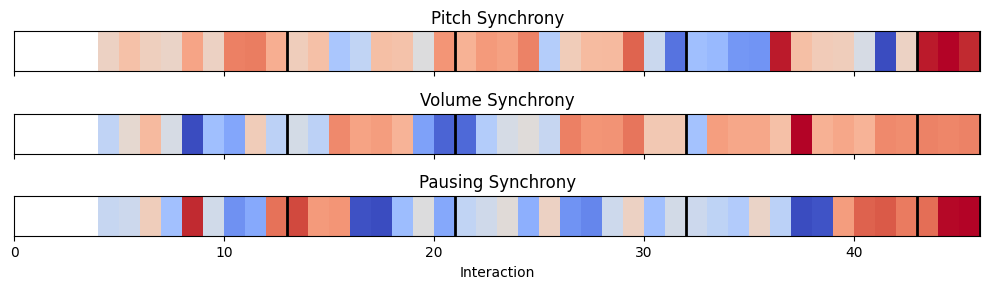

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 3), sharex=True)

# Plot frequency covariance
axs[0].imshow(freq_covariance.reshape(1, -1), cmap='coolwarm', aspect='auto', extent=[0, len(freq_covariance), 0, 1])
axs[0].set_title('Pitch Synchrony')
axs[0].set_yticks([])
axs[0].set_yticklabels([])
axs[0].axvline(x=13, color='black', linewidth=2)
axs[0].axvline(x=21, color='black', linewidth=2)
axs[0].axvline(x=32, color='black', linewidth=2)
axs[0].axvline(x=43, color='black', linewidth=2)
axs[0].axvline(x=46, color='black', linewidth=2)

# Plot volume covariance
axs[1].imshow(vol_covariance.reshape(1, -1), cmap='coolwarm', aspect='auto', extent=[0, len(vol_covariance), 0, 1])
axs[1].set_title('Volume Synchrony')
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].axvline(x=13, color='black', linewidth=2)
axs[1].axvline(x=21, color='black', linewidth=2)
axs[1].axvline(x=32, color='black', linewidth=2)
axs[1].axvline(x=43, color='black', linewidth=2)
axs[1].axvline(x=46, color='black', linewidth=2)

# Plot pause length covariance
axs[2].imshow(pause_covariance.reshape(1, -1), cmap='coolwarm', aspect='auto', extent=[0, len(pause_covariance), 0, 1])
axs[2].set_title('Pausing Synchrony')
axs[2].set_yticks([])
axs[2].set_yticklabels([])
axs[2].set_xlabel('Interaction')
axs[2].axvline(x=13, color='black', linewidth=2)
axs[2].axvline(x=21, color='black', linewidth=2)
axs[2].axvline(x=32, color='black', linewidth=2)
axs[2].axvline(x=43, color='black', linewidth=2)
axs[2].axvline(x=46, color='black', linewidth=2)

plt.tight_layout()
plt.show()


<ipython-input-129-385ed8ff3dce>:26: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(segment_y), ref=np.max)
<ipython-input-129-385ed8ff3dce>:95: RuntimeWarning: divide by zero encountered in log
  cepstrum = np.abs(np.fft.ifft(np.log(np.abs(np.fft.fft(frame)))**2))


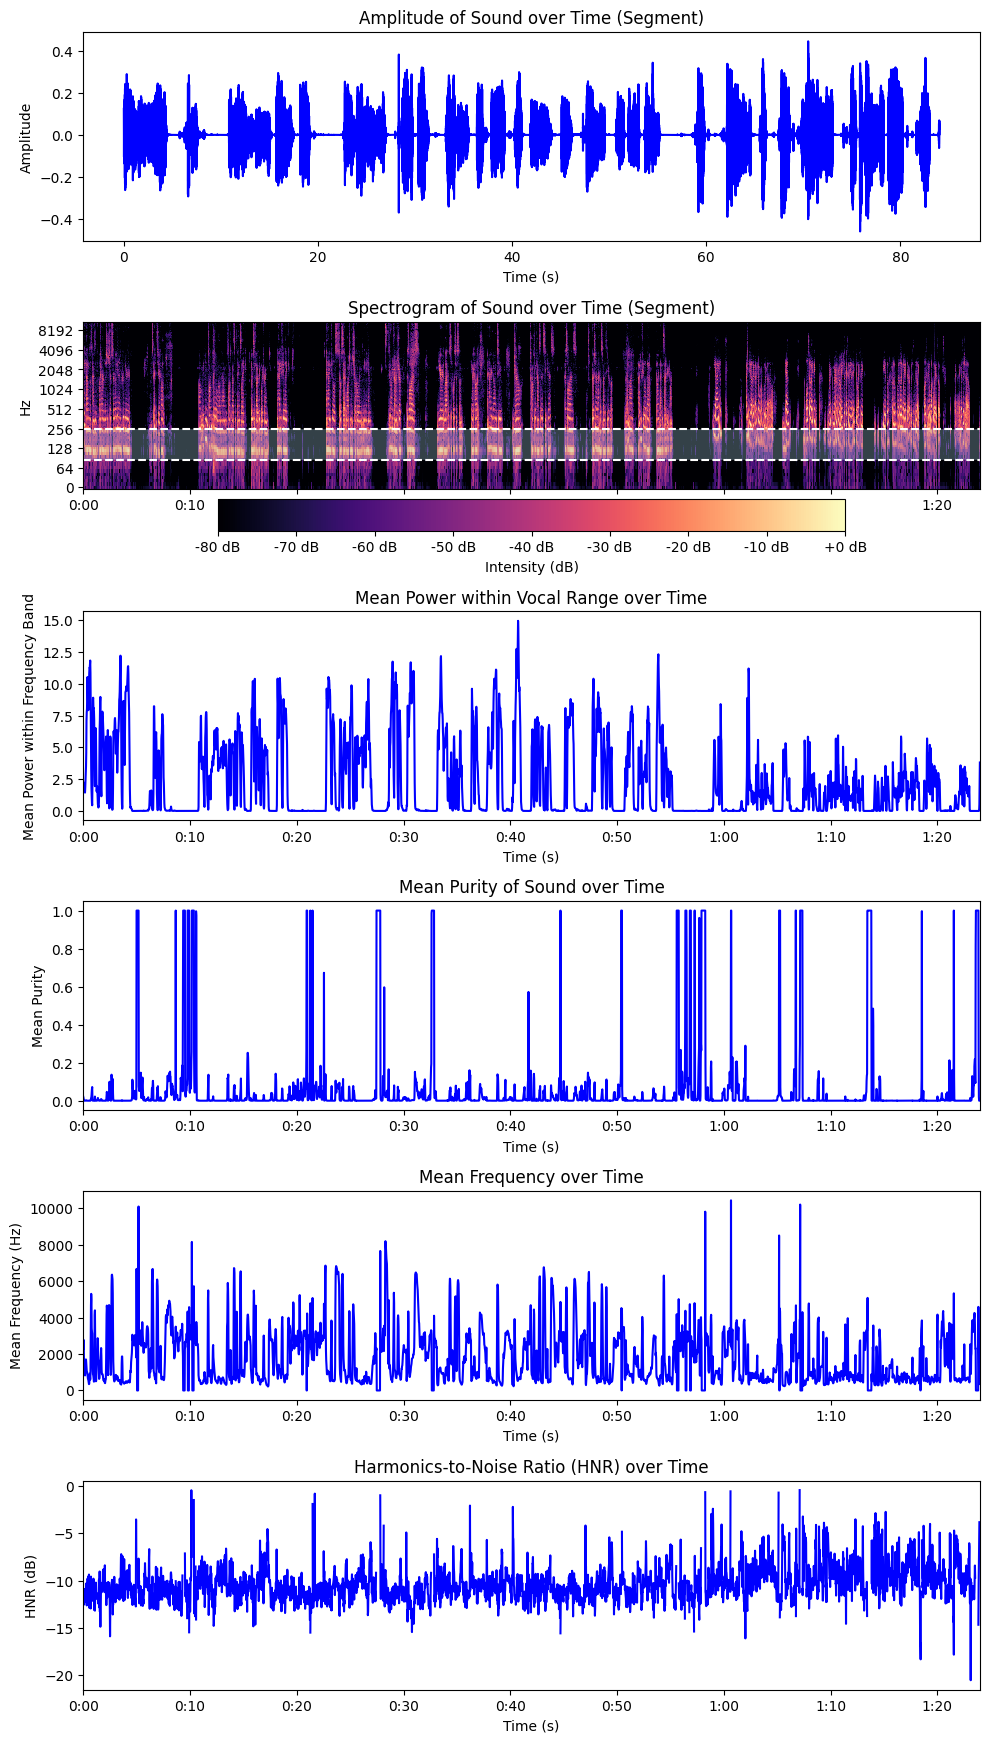

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def plot_interaction(interaction_num, listener_array, caller_array, y, sr):
    # Get start and end times for the interaction
    listener_start_time = listener_array[interaction_num][0]
    caller_end_time = caller_array[interaction_num][1]

    # Convert time to sample indices
    listener_start_sample = int(listener_start_time * sr)
    caller_end_sample = int(caller_end_time * sr)

    # Extract the segment of the audio signal
    segment_y = y[listener_start_sample:caller_end_sample]

    # Plot the amplitude of sound over time for the segment
    plt.figure(figsize=(10, 20))  # Adjust the figure size if necessary
    plt.subplot(7, 1, 1)  # Moved to the first subplot position
    plt.plot(np.arange(len(segment_y)) / sr, segment_y, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Amplitude of Sound over Time (Segment)')

    # Plot the spectrogram of the segment
    D = librosa.amplitude_to_db(librosa.stft(segment_y), ref=np.max)
    spec_ax = plt.subplot(7, 1, 2)  # Adjusted to the second subplot position
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=spec_ax)
    cbar = plt.colorbar(img, format='%+2.0f dB', orientation='horizontal', pad=0.05)
    cbar.set_label('Intensity (dB)')
    plt.title('Spectrogram of Sound over Time (Segment)')

    # Draw horizontal dashed lines for vocal frequency range
    min_freq = 85
    max_freq = 255
    plt.axhline(y=min_freq, color='white', linestyle='--', linewidth=1.5)
    plt.axhline(y=max_freq, color='white', linestyle='--', linewidth=1.5)

    # Highlight the range between min_freq and max_freq with a light blue rectangle
    xmin, xmax = plt.xlim()
    plt.axhspan(min_freq, max_freq, xmin=xmin, xmax=xmax, facecolor='lightblue', alpha=0.3)

    # Compute the spectrogram for the segment within the time window
    D_segment = np.abs(librosa.stft(segment_y))
    times_segment = librosa.times_like(D_segment)
    freqs_segment = librosa.fft_frequencies(sr=sr)

    # Find the indices corresponding to the frequency band of interest
    freq_indices = np.where((freqs_segment >= min_freq) & (freqs_segment <= max_freq))[0]

    # Extract intensity values within the frequency band of interest and the time window
    intensity_band_segment = np.mean(D_segment[freq_indices, :], axis=0)

    # Plot intensity over time within the frequency band of interest and the time window
    plt.subplot(7, 1, 3, sharex=spec_ax)  # Adjusted to the third subplot position
    plt.plot(times_segment, intensity_band_segment, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Mean Power within Frequency Band')
    plt.title('Mean Power within Vocal Range over Time')

    # Set a threshold for mean power
    power_threshold = 0.5  # Adjust this threshold as needed

    # Check if mean power exceeds the threshold
    if np.mean(intensity_band_segment) > power_threshold:
        # Compute mean purity of sound over time
        mean_purity_segment = librosa.feature.spectral_flatness(y=segment_y)

        # Plot mean purity of sound over time
        plt.subplot(7, 1, 4, sharex=spec_ax)  # Adjusted to the fourth subplot position
        plt.plot(times_segment, mean_purity_segment[0], color='b')
        plt.xlabel('Time (s)')
        plt.ylabel('Mean Purity')
        plt.title('Mean Purity of Sound over Time')

    # Compute mean frequency over time
    mean_freq_segment = librosa.feature.spectral_centroid(y=segment_y, sr=sr)[0]

    # Plot mean frequency over time
    plt.subplot(7, 1, 5, sharex=spec_ax)  # Adjusted to the fifth subplot position
    plt.plot(times_segment, mean_freq_segment, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Mean Frequency (Hz)')
    plt.title('Mean Frequency over Time')

    # Define the window size and hop length for analysis (adjust as needed)
    frame_length = 1024
    hop_length = 512

    # Compute the Harmonics-to-Noise Ratio (HNR) over time
    hnr_values = []
    for i in range(0, len(segment_y) - frame_length, hop_length):
        frame = segment_y[i:i + frame_length]
        # Compute the cepstrum
        cepstrum = np.abs(np.fft.ifft(np.log(np.abs(np.fft.fft(frame)))**2))
        # Compute the HNR as the ratio of the energy in the harmonics to the energy in the noise
        harmonics_energy = np.sum(cepstrum[1:10])  # Sum of the first 10 cepstral coefficients (excluding DC)
        noise_energy = np.sum(cepstrum[10:])  # Sum of the remaining cepstral coefficients
        hnr = harmonics_energy / noise_energy
        hnr_db = 10 * np.log10(hnr)  # Convert to dB
        hnr_values.append(hnr_db)

    # Create a time array corresponding to the computed HNR values
    time_values = np.arange(len(hnr_values)) * hop_length / sr

    # Plot the Harmonics-to-Noise Ratio (HNR) over time
    plt.subplot(7, 1, 6, sharex=spec_ax)  # Adjusted to the sixth subplot position
    plt.plot(time_values, hnr_values, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('HNR (dB)')
    plt.title('Harmonics-to-Noise Ratio (HNR) over Time')

    plt.tight_layout()
    plt.show()

# Example usage:
#interaction_num = 3  # high listener vol, low caller vol
interaction_num = 42  # high caller vol, low listener vol
plot_interaction(interaction_num, listener_array, caller_array, y, sr)


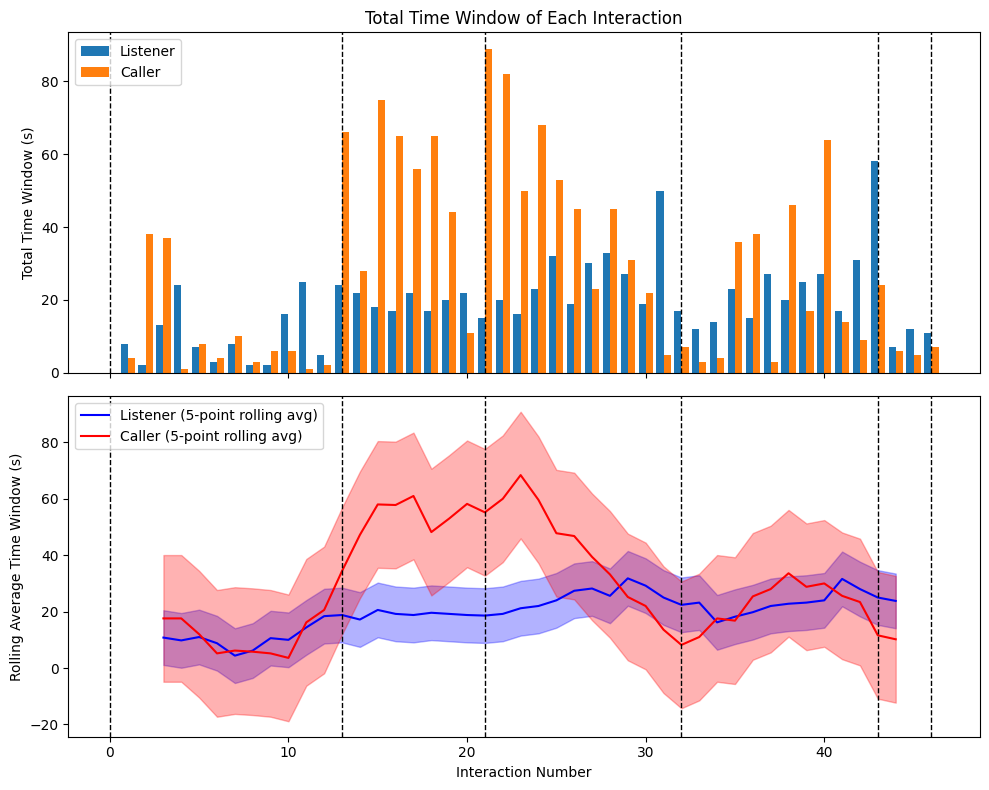

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_interaction_duration(listener_array, caller_array, window_length=3, figsize=(10, 8)):
    # Calculate the duration of each interaction for the listener and caller separately
    listener_durations = [listener[1] - listener[0] for listener in listener_array]
    caller_durations = [caller[1] - caller[0] for caller in caller_array]

    # Create an array for interaction numbers
    interaction_nums = np.arange(1, len(listener_durations) + 1)

    # Define the width of each bar
    bar_width = 0.4

    # Create a figure and subplots
    fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # Plot bar plots with staggered x-coordinates
    axs[0].bar(interaction_nums - bar_width / 2, listener_durations, width=bar_width, label='Listener')
    axs[0].bar(interaction_nums + bar_width / 2, caller_durations, width=bar_width, label='Caller')

    # Plot vertical lines at specific interaction numbers
    vertical_lines_x = [0, 13, 21, 32, 43, 46]  # Define the x coordinates of the vertical lines
    for line_x in vertical_lines_x:
        axs[0].axvline(x=line_x, color='black', linestyle='--', linewidth=1)

    # Plot rolling average line graphs for caller and listener
    rolling_avg_listener = np.convolve(listener_durations, np.ones(window_length)/window_length, mode='valid')
    rolling_avg_caller = np.convolve(caller_durations, np.ones(window_length)/window_length, mode='valid')
    interaction_nums_rolling = np.arange(window_length // 2 + 1, len(listener_durations) - window_length // 2 + 1)
    axs[1].plot(interaction_nums_rolling, rolling_avg_listener, color='blue', label=f'Listener ({window_length}-point rolling avg)')
    axs[1].plot(interaction_nums_rolling, rolling_avg_caller, color='red', label=f'Caller ({window_length}-point rolling avg)')

    # Compute standard errors
    sem_listener = np.std(listener_durations) / np.sqrt(window_length)
    sem_caller = np.std(caller_durations) / np.sqrt(window_length)

    # Compute confidence intervals using standard error
    confidence_interval_listener = 1.96 * sem_listener
    confidence_interval_caller = 1.96 * sem_caller
    upper_bound_listener = rolling_avg_listener + confidence_interval_listener
    lower_bound_listener = rolling_avg_listener - confidence_interval_listener
    upper_bound_caller = rolling_avg_caller + confidence_interval_caller
    lower_bound_caller = rolling_avg_caller - confidence_interval_caller

    # Fill confidence intervals transparently
    axs[1].fill_between(interaction_nums_rolling, lower_bound_listener, upper_bound_listener, color='blue', alpha=0.3)
    axs[1].fill_between(interaction_nums_rolling, lower_bound_caller, upper_bound_caller, color='red', alpha=0.3)

    # Plot vertical lines at specific interaction numbers
    for line_x in vertical_lines_x:
        axs[1].axvline(x=line_x, color='black', linestyle='--', linewidth=1)

    # Set labels and titles
    axs[0].set_ylabel('Total Time Window (s)')
    axs[0].set_title('Total Time Window of Each Interaction')
    axs[0].legend()
    axs[1].set_xlabel('Interaction Number')
    axs[1].set_ylabel('Rolling Average Time Window (s)')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_interaction_duration(listener_array, caller_array, window_length=5)
